# NLP Experimental

Subject : Natural Language Processing

Professsor: Adriano Veloso

Student : Jackson Smith

# Introdução

In this project, i build a classifier supervised to predict text categories.

As literature techniques use the word embeddings and two neural networks for this experiment.

For an evaluation of this work i use the Stack OverFlow public data set the was hosted on : (https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.)

Analyzing just the information about user post on stack overflow, only textual information is intended to reach the target tag that have a technolgy name e.g (c#, swift, java).

This work showed similarities between the two neural networks presented reaching an accuracy of 70% on average.

# Imports

In [1]:
import pandas as pd
import logging

import numpy as np
from numpy import random

import gensim

from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup
from sklearn import svm, datasets

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import collections
import itertools

import tensorflow as tf
from tensorflow import keras

from keras import utils
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, BatchNormalization, GRU ,concatenate
from keras.layers import InputLayer
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# Function

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

In [3]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [4]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [5]:
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [6]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

# Variables

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


# Import Data

In [8]:
df = pd.read_csv('stack-overflow-data.csv')
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


# Visualizate Data

#### Tag Quantity

[('c#', 2000), ('asp.net', 2000), ('objective-c', 2000), ('.net', 2000), ('python', 2000), ('angularjs', 2000), ('iphone', 2000), ('ruby-on-rails', 2000), ('ios', 2000), ('c', 2000)]


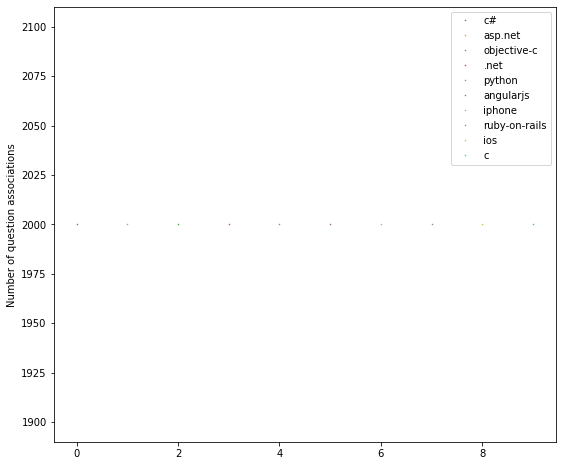

In [9]:
tagCount =  collections.Counter(list(df['tags'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

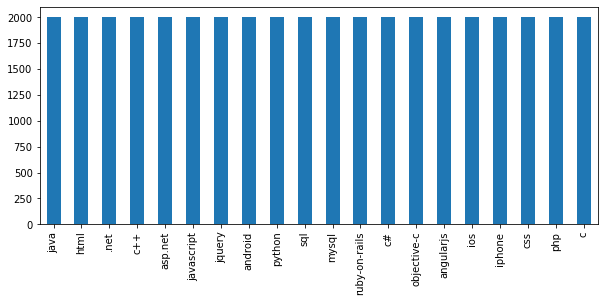

In [10]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

#### Word quantity

In [11]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

10286120

We have over 10 million words in the data.

## Clean and visualize Posts

In [12]:
print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

In [13]:
print_plot(30)

how to chain expressions inside ngclass when using the {...}[] form  how can i add another expression to an <code>ng-class</code> directive that uses this form:   <pre><code>ng-class= {true: loading   false: loading-done }[data.loader===null]  </code></pre>   i d like to add something like this to the list:   <pre><code>{highlight:isspecial} </code></pre>   is it possible without expanding the first expression     thanks.
Tag: angularjs


The text need to be cleaned up.

In [14]:
df['post'] = df['post'].apply(clean_text)

In [15]:
print_plot(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


Way better!

In [16]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424297

Now we have over 3 million words to work with.

## Separate Data into Training and Test

In [17]:
selected_tags = ['c#', 'asp.net', 'objective-c', '.net','python','angularjs','iphone', 'ruby-on-rails','ios', 'c']

df = df.loc[df['tags'].isin(selected_tags)]

X = df.post
Y = df.tags

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

### Neural Network 1

In [57]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train)

In [58]:
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

In [59]:
encoder = LabelEncoder()
encoder.fit(Y_train)

y_train = encoder.transform(Y_train)
y_test = encoder.transform(Y_test)

In [60]:
num_classes = np.max(y_train) + 1

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [61]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (14000, 1000)
x_test shape: (6000, 1000)
y_train shape: (14000, 10)
y_test shape: (6000, 10)


In [62]:
batch_size = 32
epochs = 15

In [63]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
history_one = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 12600 samples, validate on 1400 samples
Epoch 1/15
12600/12600 [==============================] - 3s 231us/step - loss: 0.0453 - accuracy: 0.9901 - val_loss: 0.8972 - val_accuracy: 0.7914
Epoch 2/15
12600/12600 [==============================] - 3s 236us/step - loss: 0.0381 - accuracy: 0.9920 - val_loss: 0.9071 - val_accuracy: 0.7943
Epoch 3/15
12600/12600 [==============================] - 3s 276us/step - loss: 0.0331 - accuracy: 0.9933 - val_loss: 0.9404 - val_accuracy: 0.7943
Epoch 4/15
12600/12600 [==============================] - 3s 252us/step - loss: 0.0300 - accuracy: 0.9928 - val_loss: 0.9854 - val_accuracy: 0.7950
Epoch 5/15
12600/12600 [==============================] - 4s 295us/step - loss: 0.0224 - accuracy: 0.9956 - val_loss: 1.0085 - val_accuracy: 0.7914
Epoch 6/15
12600/12600 [==============================] - 3s 238us/step - loss: 0.0201 - accuracy: 0.9960 - val_loss: 1.0074 - val_accuracy: 0.7921
Epoch 7/15
12600/12600 [==============================] - 3s 23

In [66]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

6000/6000 [==============================] - 0s 70us/step
Test accuracy: 0.7891666889190674


In [67]:
y_pred = model.predict_classes(x_test, verbose=1)

6000/6000 [==============================] - 0s 69us/step


In [86]:
print('accuracy %s' % accuracy_score(y_pred, y_test.argmax(-1)))

print(classification_report(y_test.argmax(-1), y_pred, target_names=Y_test.unique()))

accuracy 0.7891666666666667
               precision    recall  f1-score   support

          ios       0.69      0.65      0.67       629
       iphone       0.98      0.95      0.97       572
      asp.net       0.78      0.79      0.79       606
  objective-c       0.92      0.90      0.91       609
ruby-on-rails       0.69      0.73      0.71       625
         .net       0.63      0.59      0.61       620
           c#       0.64      0.70      0.67       580
            c       0.69      0.70      0.69       600
       python       0.95      0.95      0.95       571
    angularjs       0.96      0.95      0.95       588

     accuracy                           0.79      6000
    macro avg       0.79      0.79      0.79      6000
 weighted avg       0.79      0.79      0.79      6000



Confusion matrix, without normalization


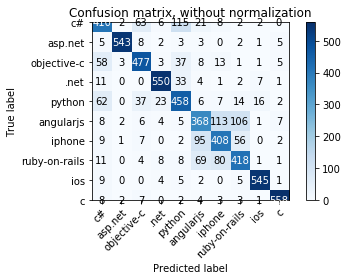

In [68]:
fig,ax = plot_confusion_matrix(y_test.argmax(-1), y_pred, classes= df.tags.unique(),
                      title='Confusion matrix, without normalization')

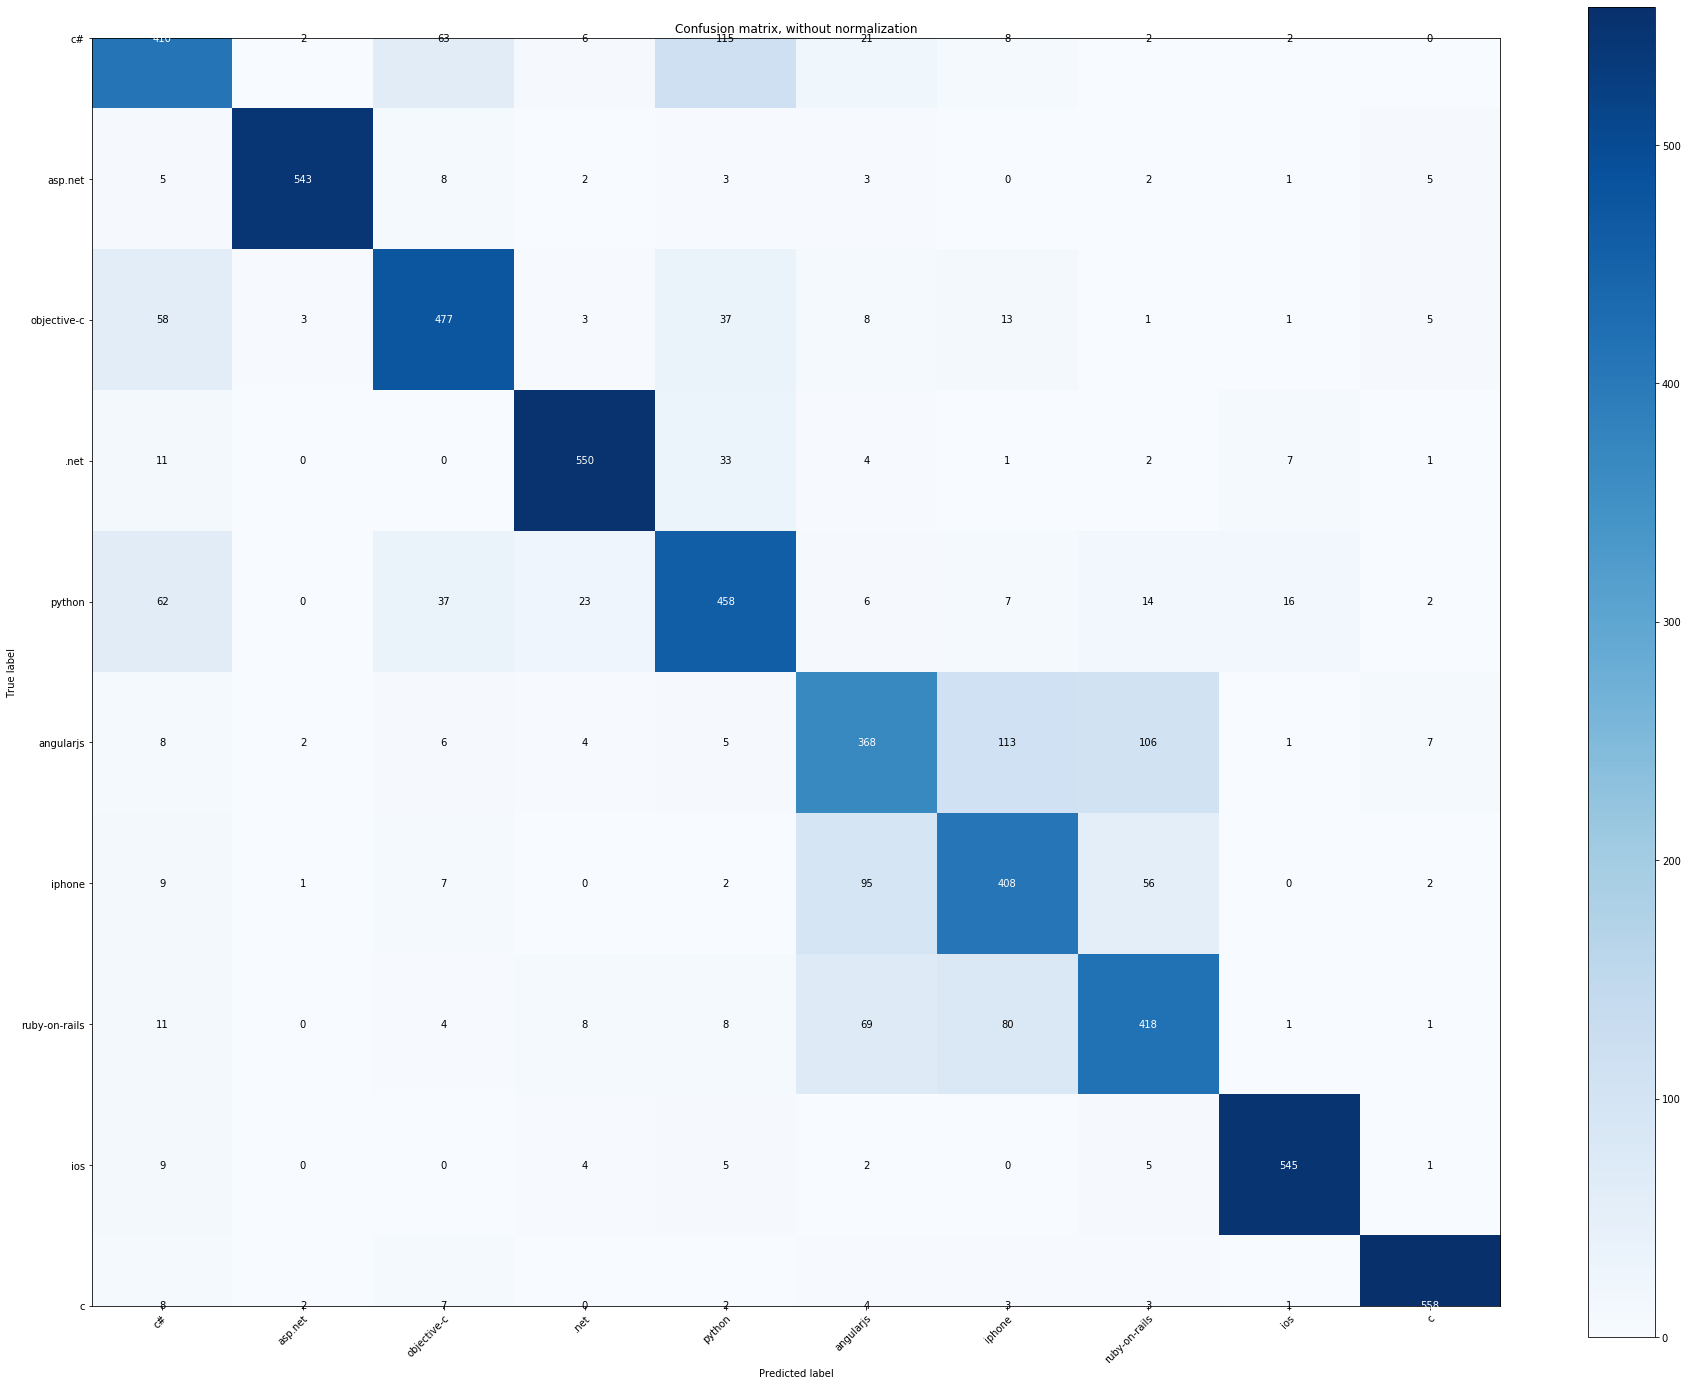

In [69]:
fig.set_figheight(30)
fig.set_figwidth(30)
fig

In [70]:
score

[1.3090059310595195, 0.7891666889190674]

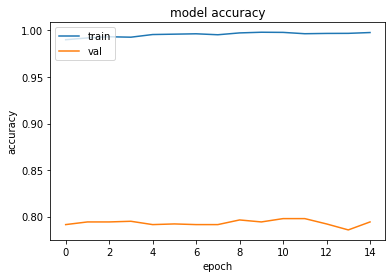

In [83]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_one.history['accuracy'])
plt.plot(history_one.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

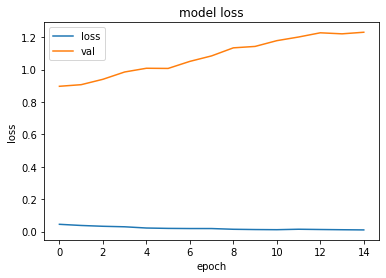

In [87]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_one.history['loss'])
plt.plot(history_one.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

### Neural Network 2

In [30]:
lb = LabelBinarizer()

y_train= lb.fit_transform(Y_train)
y_test= lb.fit_transform(Y_test)

In [31]:
sent_size = []

for sent in X_train:
    sent_size.append(len(word_tokenize(sent)))

In [32]:
max_sent_size = max(sent_size)
max_size = np.quantile(max_sent_size, 0.97).astype(np.int64)

tokenizer = Tokenizer(char_level=False,split=' ')
tokenizer.fit_on_texts(X_train)


In [33]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_matrix_train = sequence.pad_sequences(sequences_train, maxlen= max_size)

In [34]:
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen= max_size)

In [35]:
sequences_matrix_train.shape, sequences_matrix_test.shape, y_train.shape,y_test.shape

((14000, 2282), (6000, 2282), (14000, 10), (6000, 10))

In [36]:
vocab_size =len(tokenizer.index_word.keys())

vocab_size

99398

In [37]:
model = Sequential()
model.add(InputLayer(input_shape= ( max_size, ) ))
model.add(Embedding(vocab_size + 12000, 128))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
          
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2282, 128)         14258944  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 14,351,554
Trainable params: 14,351,554
Non-trainable params: 0
_________________________________________________________________


In [38]:
results = model.fit(sequences_matrix_train, y_train, batch_size=128, epochs=13, validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11200 samples, validate on 2800 samples
Epoch 1/13
11200/11200 [==============================] - 553s 49ms/step - loss: 2.0163 - accuracy: 0.2665 - ignore_accuracy: 0.2765 - val_loss: 1.6126 - val_accuracy: 0.3429 - val_ignore_accuracy: 0.3507
Epoch 2/13
11200/11200 [==============================] - 565s 50ms/step - loss: 1.4043 - accuracy: 0.4719 - ignore_accuracy: 0.4948 - val_loss: 1.1881 - val_accuracy: 0.5561 - val_ignore_accuracy: 0.5612
Epoch 3/13
11200/11200 [==============================] - 555s 50ms/step - loss: 0.9322 - accuracy: 0.6640 - ignore_accuracy: 0.6763 - val_loss: 0.8919 - val_accuracy: 0.6679 - val_ignore_accuracy: 0.6951
Epoch 4/13
11200/11200 [==============================] - 504s 45ms/step - loss: 0.5798 - accuracy: 0.8020 - ignore_accuracy: 0.8067 - val_loss: 0.7806 - val_accuracy: 0.7164 - val_ignore_accuracy: 0.7264
Epoch 5/13
11200/11200 [==============================] - 549s 49ms/step - loss: 0.4445 - accuracy: 0.8571 - ignore_accuracy: 0.862

In [39]:
y_pred = model.predict_classes(sequences_matrix_test, verbose=1)

6000/6000 [==============================] - 64s 11ms/step


In [42]:
print('accuracy %s' % accuracy_score(y_pred, y_test.argmax(-1)))

print(classification_report(y_test.argmax(-1), y_pred, target_names=Y_test.unique()))

accuracy 0.7313333333333333
               precision    recall  f1-score   support

          ios       0.62      0.60      0.61       629
       iphone       0.94      0.96      0.95       572
      asp.net       0.74      0.75      0.74       606
  objective-c       0.86      0.91      0.89       609
ruby-on-rails       0.63      0.66      0.64       625
         .net       0.58      0.52      0.55       620
           c#       0.55      0.51      0.53       580
            c       0.56      0.64      0.60       600
       python       0.92      0.88      0.90       571
    angularjs       0.94      0.92      0.93       588

     accuracy                           0.73      6000
    macro avg       0.73      0.73      0.73      6000
 weighted avg       0.73      0.73      0.73      6000



Confusion matrix, without normalization


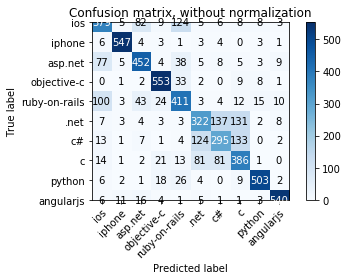

In [45]:
fig,ax = plot_confusion_matrix(y_test.argmax(-1), y_pred, classes= Y_test.unique(),
                      title='Confusion matrix, without normalization')

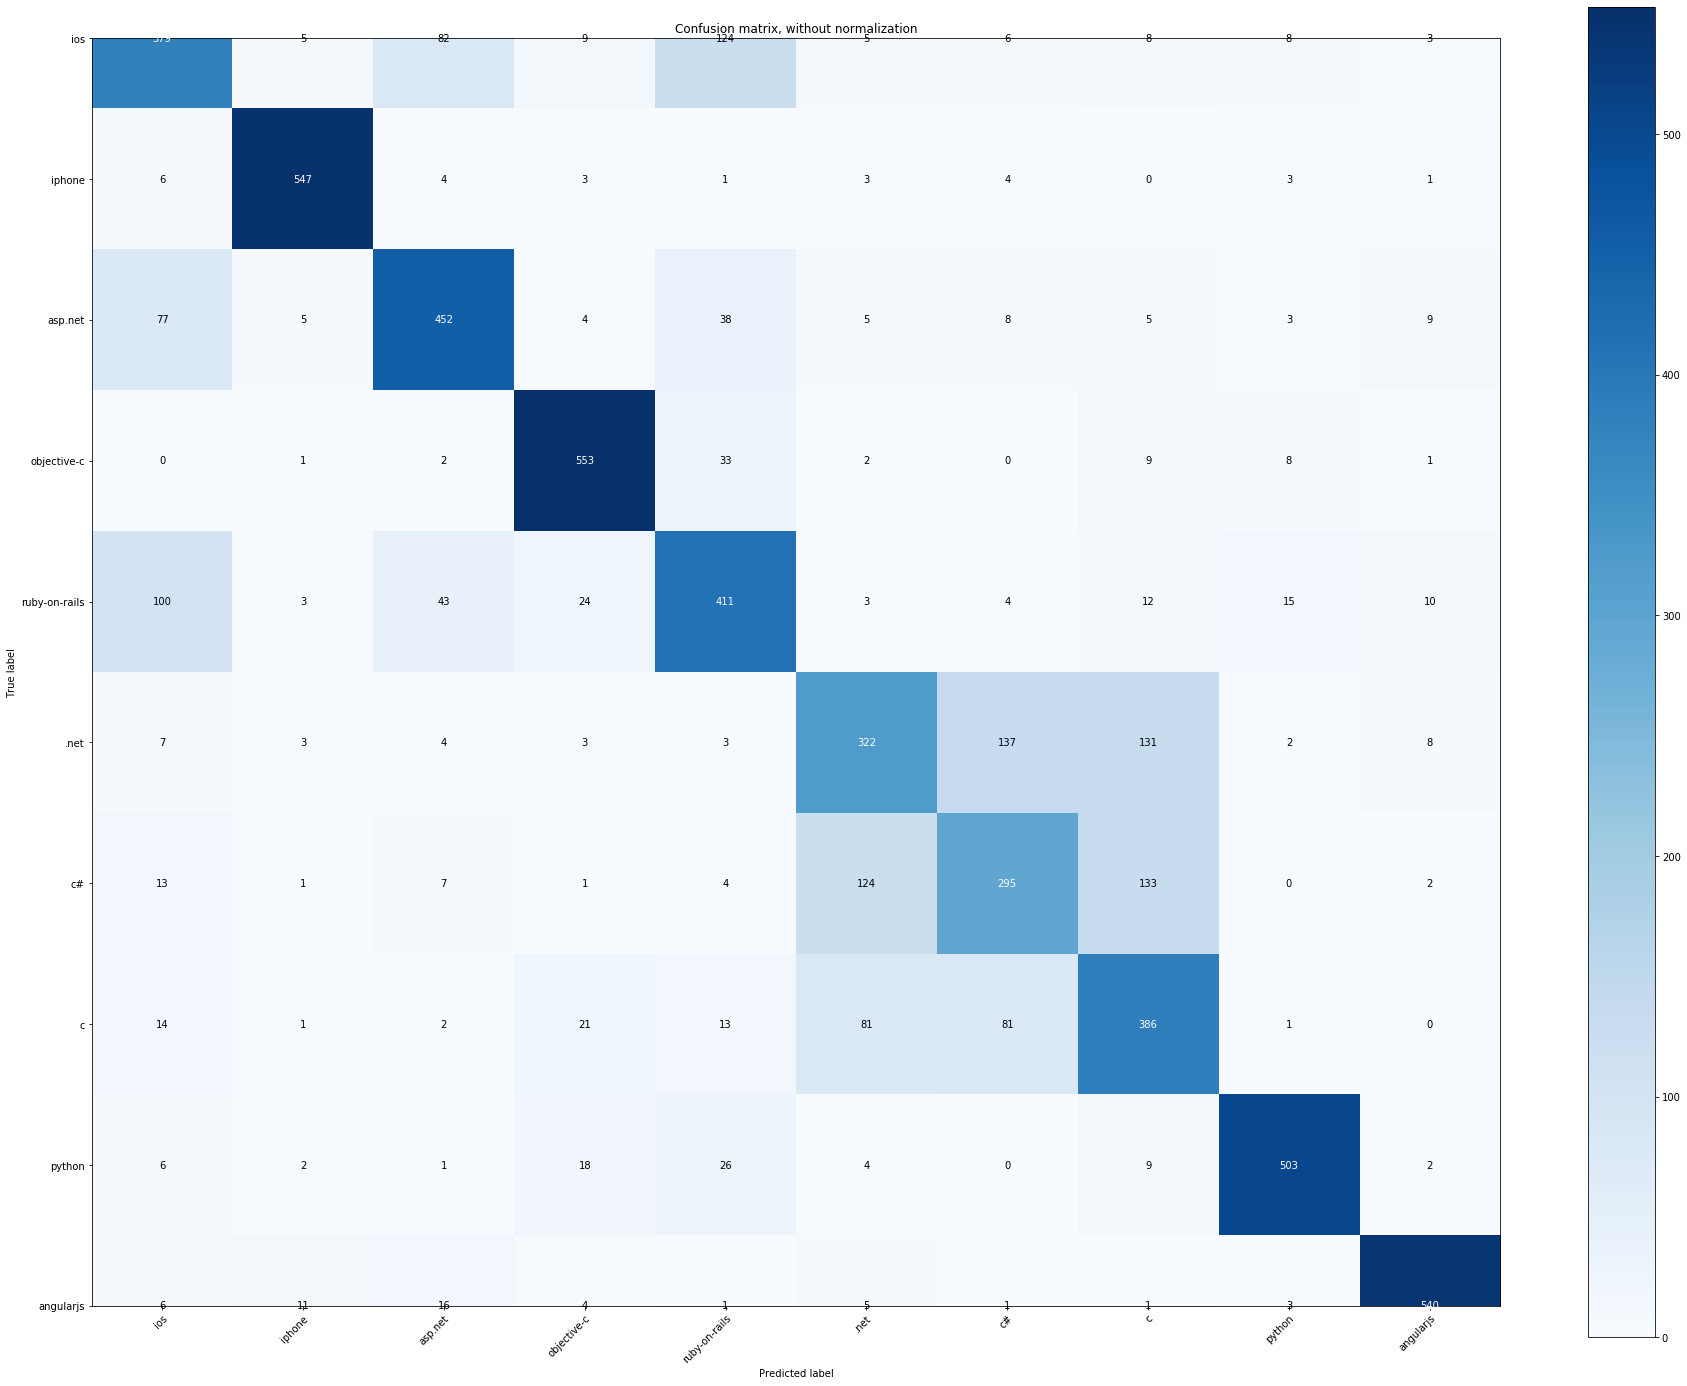

In [46]:
fig.set_figheight(30)
fig.set_figwidth(30)
fig

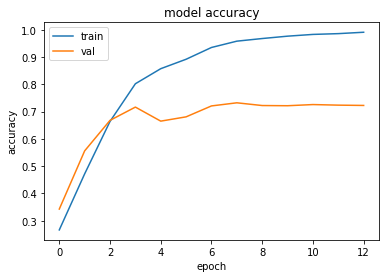

In [82]:
import keras
from matplotlib import pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

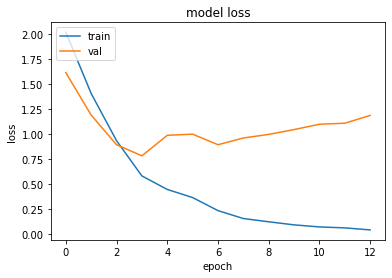

In [85]:
import keras
from matplotlib import pyplot as plt
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results

Although the LSTM algorithm is strongly recommended for sequences, it was no better than it was the first neural network.

The results were satisfactory and there is a likelihood that better results would be presented if more features were used, such as text title and body separation and user preference technologies.